In [12]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split, cross_val_score
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Dense, LeakyReLU, Flatten, BatchNormalization
from tensorflow.keras.models import Model, Sequential, model_from_json
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings("ignore")

df = pd.read_csv('../data/raw/intern_data.csv', index_col=0)
num_cols = ['a', 'b', 'd', 'e', 'f', 'g']
ctg_cols = ['c', 'h']
Y_LABEL = 'y'
df_dummy = pd.get_dummies(df, columns=ctg_cols)
df_dummy

,a,b,d,e,f,g,y,c_blue,c_green,c_red,c_yellow,h_black,h_white
7,0.951786,0.669570,0.170130,0.623469,0.925886,0.812685,3.707514,0,1,0,0,0,1
43,0.510447,0.922627,0.087899,0.025415,0.698444,0.658545,2.689243,0,0,1,0,0,1
47,0.294838,0.351081,0.710892,0.699661,0.545722,0.836863,2.886508,0,0,0,1,1,0
53,0.798645,0.572042,0.026137,0.609730,0.488668,0.342675,2.478168,0,1,0,0,1,0
54,0.689666,0.395323,0.172448,0.736433,0.708408,0.695521,3.182666,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4889,0.195745,0.791511,0.784001,0.778692,0.407301,0.895939,3.646691,0,1,0,0,0,1
4910,0.995119,0.076542,0.326500,0.829949,0.500763,0.545784,3.270344,0,0,0,1,0,1
4920,0.091773,0.326965,0.922553,0.257745,0.348771,0.624851,2.672514,0,1,0,0,0,1
4931,0.761853,0.654755,0.252334,0.128781,0.658069,0.405367,1.259850,1,0,0,0,1,0


In [7]:
def normalize_data(df_input, scaler='robust'):
    result = df_input.copy(deep=True)
    if scaler == 'robust':
        num_pipeline = Pipeline([('robust_scaler', RobustScaler())])
    else:
        num_pipeline = Pipeline([('std_scaler', StandardScaler())])    
    #column_to_nmlz = list(set(df_input.columns) - set([Y_LABEL]))
    column_to_nmlz = num_cols
    result[column_to_nmlz] = num_pipeline.fit_transform(df_input[column_to_nmlz])
    return result
df_dummy_normed = normalize_data(df_dummy, scaler='std')
df_dummy_normed

,a,b,d,e,f,g,y,c_blue,c_green,c_red,c_yellow,h_black,h_white
7,1.552595,0.561935,-1.166187,0.447364,1.368097,1.071096,3.707514,0,1,0,0,0,1
43,0.044537,1.428104,-1.455388,-1.753411,0.588872,0.528442,2.689243,0,0,1,0,0,1
47,-0.692202,-0.528193,0.735634,0.727741,0.065641,1.156217,2.886508,0,0,0,1,1,0
53,1.029311,0.228115,-1.672603,0.396806,-0.129825,-0.583588,2.478168,0,1,0,0,1,0
54,0.656931,-0.376760,-1.158036,0.863059,0.623012,0.658619,3.182666,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4889,-1.030802,0.979316,0.992755,1.018567,-0.408593,1.364197,3.646691,0,1,0,0,0,1
4910,1.700667,-1.467889,-0.616245,1.207189,-0.088388,0.131463,3.270344,0,0,0,1,0,1
4920,-1.386076,-0.610738,1.480035,-0.898462,-0.609117,0.409822,2.672514,0,1,0,0,0,1
4931,0.903592,0.511226,-0.877083,-1.373038,0.450548,-0.362880,1.259850,1,0,0,0,1,0


In [10]:
def get_train_test_sets(test_size=0.2, dummy=False, normed=False):
    if dummy is True and normed is True:
        df_input = df_dummy_normed
    elif dummy is True and normed is False:
        df_input = df_dummy
    else:
        df_input = df
            
    train_set, test_set = train_test_split(df_input, test_size=test_size, random_state=42)
    x_train = train_set.drop(columns=[Y_LABEL], axis=1)
    x_test = test_set.drop(columns=[Y_LABEL], axis=1)
    #y_train, y_test = num_pipeline.fit_transform(train_set[[Y_LABEL]]), num_pipeline.fit_transform(test_set[[Y_LABEL]])
    y_train, y_test = train_set[Y_LABEL], test_set[Y_LABEL]
    return x_train, x_test, y_train, y_test

x_train, x_test, y_train, y_test = get_train_test_sets(dummy=True, normed=True)
x_test

,a,b,d,e,f,g,c_blue,c_green,c_red,c_yellow,h_black,h_white
3584,-1.556345,0.770012,-0.174400,0.490193,-0.475898,0.624549,0,0,0,1,0,1
724,0.688401,-1.141503,1.241665,0.606089,1.358673,-0.050138,0,1,0,0,0,1
3698,-0.097794,1.682753,-0.282800,-0.283596,1.133102,1.403830,0,1,0,0,0,1
1516,-0.129293,0.366591,-1.169818,-1.521608,-0.988275,-0.870718,0,0,0,1,1,0
1014,1.602936,-0.142387,-1.034045,0.898329,-1.205260,-0.024376,0,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
3461,-0.697763,-0.925020,0.910509,-1.612282,0.424043,1.054797,0,0,0,1,0,1
880,-1.666632,-1.720522,-0.042141,0.432283,-1.253381,0.650506,0,1,0,0,0,1
731,0.530438,-0.985447,-1.023980,-1.460383,0.655236,-1.681786,0,0,1,0,1,0
4273,1.440588,-1.449917,0.709627,-1.738525,1.332584,0.486928,1,0,0,0,0,1


In [15]:
def coeff_determination(y_true, y_pred):
    SS_res = K.sum(K.square(y_true - y_pred))
    SS_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return 1 - SS_res / (SS_tot + K.epsilon())


def create_keras_model(optimizer='adam', neuron=50, init='lecun_normal', act_alpha=0.01):
    model_sequences = [
        keras.layers.Dense(units=neuron, kernel_initializer=init, input_shape=x_train.shape[1:]),
        keras.layers.LeakyReLU(alpha=act_alpha)
    ]

    for i in range(5):
        model_sequences.append(keras.layers.Dense(units=neuron, kernel_initializer=init, input_shape=x_train.shape[1:]))
        model_sequences.append(keras.layers.LeakyReLU(alpha=act_alpha))

    # model_sequences.append(keras.layers.BatchNormalization())
    model_sequences.append(Dense(units=1, name='score_output'))
    model_sequences.append(keras.layers.LeakyReLU(alpha=act_alpha))
    # model_sequences.append(keras.layers.Activation(activation))

    nn_model = keras.models.Sequential(model_sequences)
    nn_model.compile(optimizer=optimizer, loss='mae', metrics=[coeff_determination])
    return nn_model

def save_keras_model(model, history):
    model_json = model.to_json()
    with open("../models/ANN.json", 'w') as json_file:
        json_file.write(model_json)
    model.save_weights("../models/ANN.h5")
    with open('../models/ANN.history', 'wb') as file_history:
        pickle.dump(history.history, file_history)
    print("model saved")

Keras model constructed
Train on 400 samples, validate on 100 samples
Epoch 1/1000
400/400 [==============================] - 1s 3ms/step - loss: 2.3639 - coeff_determination: -18.3337 - val_loss: 1.1635 - val_coeff_determination: -4.4993
Epoch 2/1000
400/400 [==============================] - 0s 175us/step - loss: 0.8446 - coeff_determination: -2.3930 - val_loss: 0.7191 - val_coeff_determination: -1.4174
Epoch 3/1000
400/400 [==============================] - 0s 165us/step - loss: 0.6269 - coeff_determination: -0.7896 - val_loss: 0.6165 - val_coeff_determination: -0.5552
Epoch 4/1000
400/400 [==============================] - 0s 156us/step - loss: 0.4805 - coeff_determination: -0.0583 - val_loss: 0.7631 - val_coeff_determination: -1.2050
Epoch 5/1000
400/400 [==============================] - 0s 128us/step - loss: 0.5617 - coeff_determination: -0.3309 - val_loss: 0.7823 - val_coeff_determination: -1.1945
Epoch 6/1000
400/400 [==============================] - 0s 157us/step - loss: 0.5

400/400 [==============================] - 0s 172us/step - loss: 0.1695 - coeff_determination: 0.8740 - val_loss: 0.2390 - val_coeff_determination: 0.7697
Epoch 50/1000
400/400 [==============================] - 0s 112us/step - loss: 0.1804 - coeff_determination: 0.8611 - val_loss: 0.1442 - val_coeff_determination: 0.9003
Epoch 51/1000
400/400 [==============================] - 0s 109us/step - loss: 0.1781 - coeff_determination: 0.8569 - val_loss: 0.1543 - val_coeff_determination: 0.8876
Epoch 52/1000
400/400 [==============================] - 0s 107us/step - loss: 0.1681 - coeff_determination: 0.8722 - val_loss: 0.2082 - val_coeff_determination: 0.8220
Epoch 53/1000
400/400 [==============================] - 0s 93us/step - loss: 0.1791 - coeff_determination: 0.8640 - val_loss: 0.2133 - val_coeff_determination: 0.8111
Epoch 54/1000
400/400 [==============================] - 0s 100us/step - loss: 0.1612 - coeff_determination: 0.8823 - val_loss: 0.1645 - val_coeff_determination: 0.8788
E

400/400 [==============================] - 0s 116us/step - loss: 0.1273 - coeff_determination: 0.9225 - val_loss: 0.1551 - val_coeff_determination: 0.8929
Epoch 98/1000
400/400 [==============================] - 0s 121us/step - loss: 0.1180 - coeff_determination: 0.9354 - val_loss: 0.1797 - val_coeff_determination: 0.8671
Epoch 99/1000
400/400 [==============================] - 0s 128us/step - loss: 0.1104 - coeff_determination: 0.9460 - val_loss: 0.1419 - val_coeff_determination: 0.9045
Epoch 100/1000
400/400 [==============================] - 0s 122us/step - loss: 0.1176 - coeff_determination: 0.9371 - val_loss: 0.1375 - val_coeff_determination: 0.9211
Epoch 101/1000
400/400 [==============================] - 0s 132us/step - loss: 0.1203 - coeff_determination: 0.9328 - val_loss: 0.1550 - val_coeff_determination: 0.8930
Epoch 102/1000
400/400 [==============================] - 0s 110us/step - loss: 0.0928 - coeff_determination: 0.9572 - val_loss: 0.1363 - val_coeff_determination: 0.91

Epoch 145/1000
400/400 [==============================] - 0s 123us/step - loss: 0.0831 - coeff_determination: 0.9671 - val_loss: 0.1251 - val_coeff_determination: 0.9275
Epoch 146/1000
400/400 [==============================] - 0s 106us/step - loss: 0.0735 - coeff_determination: 0.9730 - val_loss: 0.1477 - val_coeff_determination: 0.9097
Epoch 147/1000
400/400 [==============================] - 0s 102us/step - loss: 0.0810 - coeff_determination: 0.9687 - val_loss: 0.1186 - val_coeff_determination: 0.9325
Epoch 148/1000
400/400 [==============================] - 0s 118us/step - loss: 0.0932 - coeff_determination: 0.9609 - val_loss: 0.1154 - val_coeff_determination: 0.9417
Epoch 149/1000
400/400 [==============================] - 0s 121us/step - loss: 0.0868 - coeff_determination: 0.9665 - val_loss: 0.1206 - val_coeff_determination: 0.9303
Epoch 150/1000
400/400 [==============================] - 0s 121us/step - loss: 0.0926 - coeff_determination: 0.9591 - val_loss: 0.1168 - val_coeff_de

400/400 [==============================] - 0s 115us/step - loss: 0.0574 - coeff_determination: 0.9839 - val_loss: 0.1323 - val_coeff_determination: 0.9215
Epoch 194/1000
400/400 [==============================] - 0s 120us/step - loss: 0.0824 - coeff_determination: 0.9657 - val_loss: 0.1300 - val_coeff_determination: 0.9259
Epoch 195/1000
400/400 [==============================] - 0s 129us/step - loss: 0.0548 - coeff_determination: 0.9836 - val_loss: 0.1306 - val_coeff_determination: 0.9291
Epoch 196/1000
400/400 [==============================] - 0s 126us/step - loss: 0.0744 - coeff_determination: 0.9707 - val_loss: 0.1085 - val_coeff_determination: 0.9483
Epoch 197/1000
400/400 [==============================] - 0s 114us/step - loss: 0.0699 - coeff_determination: 0.9753 - val_loss: 0.1156 - val_coeff_determination: 0.9369
Epoch 198/1000
400/400 [==============================] - 0s 117us/step - loss: 0.0632 - coeff_determination: 0.9772 - val_loss: 0.1471 - val_coeff_determination: 0.

400/400 [==============================] - 0s 121us/step - loss: 0.0699 - coeff_determination: 0.9774 - val_loss: 0.1294 - val_coeff_determination: 0.9249
Epoch 242/1000
400/400 [==============================] - 0s 117us/step - loss: 0.0616 - coeff_determination: 0.9800 - val_loss: 0.1256 - val_coeff_determination: 0.9291
Epoch 243/1000
400/400 [==============================] - 0s 118us/step - loss: 0.0679 - coeff_determination: 0.9786 - val_loss: 0.1097 - val_coeff_determination: 0.9451
Epoch 244/1000
400/400 [==============================] - 0s 114us/step - loss: 0.0695 - coeff_determination: 0.9765 - val_loss: 0.1336 - val_coeff_determination: 0.9187
Epoch 245/1000
400/400 [==============================] - 0s 118us/step - loss: 0.0613 - coeff_determination: 0.9808 - val_loss: 0.1377 - val_coeff_determination: 0.9197
Epoch 246/1000
400/400 [==============================] - 0s 109us/step - loss: 0.0695 - coeff_determination: 0.9765 - val_loss: 0.1157 - val_coeff_determination: 0.

400/400 [==============================] - 0s 122us/step - loss: 0.0609 - coeff_determination: 0.9826 - val_loss: 0.1179 - val_coeff_determination: 0.9356
Epoch 290/1000
400/400 [==============================] - 0s 119us/step - loss: 0.0594 - coeff_determination: 0.9824 - val_loss: 0.1202 - val_coeff_determination: 0.9344
Epoch 291/1000
400/400 [==============================] - 0s 108us/step - loss: 0.0564 - coeff_determination: 0.9845 - val_loss: 0.1103 - val_coeff_determination: 0.9440
Epoch 292/1000
400/400 [==============================] - 0s 115us/step - loss: 0.0515 - coeff_determination: 0.9870 - val_loss: 0.1110 - val_coeff_determination: 0.9439
Epoch 293/1000
400/400 [==============================] - 0s 105us/step - loss: 0.0551 - coeff_determination: 0.9834 - val_loss: 0.1364 - val_coeff_determination: 0.9151
Epoch 294/1000
400/400 [==============================] - 0s 121us/step - loss: 0.0665 - coeff_determination: 0.9789 - val_loss: 0.1130 - val_coeff_determination: 0.

400/400 [==============================] - 0s 137us/step - loss: 0.0591 - coeff_determination: 0.9830 - val_loss: 0.1252 - val_coeff_determination: 0.9316
Epoch 338/1000
400/400 [==============================] - 0s 120us/step - loss: 0.0668 - coeff_determination: 0.9802 - val_loss: 0.1256 - val_coeff_determination: 0.9292
Epoch 339/1000
400/400 [==============================] - 0s 111us/step - loss: 0.0672 - coeff_determination: 0.9793 - val_loss: 0.1109 - val_coeff_determination: 0.9442
Epoch 340/1000
400/400 [==============================] - 0s 121us/step - loss: 0.0547 - coeff_determination: 0.9860 - val_loss: 0.1338 - val_coeff_determination: 0.9174
Epoch 341/1000
400/400 [==============================] - 0s 116us/step - loss: 0.0636 - coeff_determination: 0.9801 - val_loss: 0.1323 - val_coeff_determination: 0.9230
Epoch 342/1000
400/400 [==============================] - 0s 109us/step - loss: 0.0628 - coeff_determination: 0.9821 - val_loss: 0.1179 - val_coeff_determination: 0.

400/400 [==============================] - 0s 114us/step - loss: 0.0623 - coeff_determination: 0.9820 - val_loss: 0.1201 - val_coeff_determination: 0.9339
Epoch 386/1000
400/400 [==============================] - 0s 114us/step - loss: 0.0603 - coeff_determination: 0.9836 - val_loss: 0.1268 - val_coeff_determination: 0.9294
Epoch 387/1000
400/400 [==============================] - 0s 117us/step - loss: 0.0597 - coeff_determination: 0.9825 - val_loss: 0.1307 - val_coeff_determination: 0.9238
Epoch 388/1000
400/400 [==============================] - 0s 120us/step - loss: 0.0632 - coeff_determination: 0.9821 - val_loss: 0.1264 - val_coeff_determination: 0.9302
Epoch 389/1000
400/400 [==============================] - 0s 129us/step - loss: 0.0532 - coeff_determination: 0.9858 - val_loss: 0.1211 - val_coeff_determination: 0.9366
Epoch 390/1000
400/400 [==============================] - 0s 119us/step - loss: 0.0483 - coeff_determination: 0.9882 - val_loss: 0.1186 - val_coeff_determination: 0.

400/400 [==============================] - 0s 112us/step - loss: 0.0575 - coeff_determination: 0.9846 - val_loss: 0.1138 - val_coeff_determination: 0.9425
Epoch 434/1000
400/400 [==============================] - 0s 118us/step - loss: 0.0572 - coeff_determination: 0.9852 - val_loss: 0.1135 - val_coeff_determination: 0.9410
Epoch 435/1000
400/400 [==============================] - 0s 125us/step - loss: 0.0568 - coeff_determination: 0.9857 - val_loss: 0.1315 - val_coeff_determination: 0.9268
Epoch 436/1000
400/400 [==============================] - 0s 105us/step - loss: 0.0519 - coeff_determination: 0.9875 - val_loss: 0.1318 - val_coeff_determination: 0.9237
Epoch 437/1000
400/400 [==============================] - 0s 114us/step - loss: 0.0571 - coeff_determination: 0.9848 - val_loss: 0.1285 - val_coeff_determination: 0.9298
Epoch 438/1000
400/400 [==============================] - 0s 116us/step - loss: 0.0514 - coeff_determination: 0.9872 - val_loss: 0.1295 - val_coeff_determination: 0.

400/400 [==============================] - 0s 114us/step - loss: 0.0552 - coeff_determination: 0.9859 - val_loss: 0.1291 - val_coeff_determination: 0.9301
Epoch 482/1000
400/400 [==============================] - 0s 120us/step - loss: 0.0452 - coeff_determination: 0.9889 - val_loss: 0.1125 - val_coeff_determination: 0.9393
Epoch 483/1000
400/400 [==============================] - 0s 118us/step - loss: 0.0476 - coeff_determination: 0.9884 - val_loss: 0.1301 - val_coeff_determination: 0.9283
Epoch 484/1000
400/400 [==============================] - 0s 116us/step - loss: 0.0580 - coeff_determination: 0.9840 - val_loss: 0.1229 - val_coeff_determination: 0.9301
Epoch 485/1000
400/400 [==============================] - 0s 112us/step - loss: 0.0459 - coeff_determination: 0.9904 - val_loss: 0.1106 - val_coeff_determination: 0.9447
Epoch 486/1000
400/400 [==============================] - 0s 103us/step - loss: 0.0473 - coeff_determination: 0.9890 - val_loss: 0.1145 - val_coeff_determination: 0.

400/400 [==============================] - 0s 110us/step - loss: 0.0508 - coeff_determination: 0.9882 - val_loss: 0.1110 - val_coeff_determination: 0.9434
Epoch 530/1000
400/400 [==============================] - 0s 117us/step - loss: 0.0447 - coeff_determination: 0.9904 - val_loss: 0.1072 - val_coeff_determination: 0.9481
Epoch 531/1000
400/400 [==============================] - 0s 109us/step - loss: 0.0423 - coeff_determination: 0.9911 - val_loss: 0.1118 - val_coeff_determination: 0.9422
Epoch 532/1000
400/400 [==============================] - 0s 113us/step - loss: 0.0516 - coeff_determination: 0.9877 - val_loss: 0.1105 - val_coeff_determination: 0.9445
Epoch 533/1000
400/400 [==============================] - 0s 104us/step - loss: 0.0546 - coeff_determination: 0.9870 - val_loss: 0.1189 - val_coeff_determination: 0.9334
Epoch 534/1000
400/400 [==============================] - 0s 116us/step - loss: 0.0533 - coeff_determination: 0.9874 - val_loss: 0.1067 - val_coeff_determination: 0.

400/400 [==============================] - 0s 106us/step - loss: 0.0491 - coeff_determination: 0.9891 - val_loss: 0.1254 - val_coeff_determination: 0.9267
Epoch 578/1000
400/400 [==============================] - 0s 116us/step - loss: 0.0545 - coeff_determination: 0.9866 - val_loss: 0.1192 - val_coeff_determination: 0.9395
Epoch 579/1000
400/400 [==============================] - 0s 122us/step - loss: 0.0492 - coeff_determination: 0.9889 - val_loss: 0.1087 - val_coeff_determination: 0.9455
Epoch 580/1000
400/400 [==============================] - 0s 119us/step - loss: 0.0505 - coeff_determination: 0.9885 - val_loss: 0.1154 - val_coeff_determination: 0.9406
Epoch 581/1000
400/400 [==============================] - 0s 115us/step - loss: 0.0528 - coeff_determination: 0.9878 - val_loss: 0.1071 - val_coeff_determination: 0.9446
Epoch 582/1000
400/400 [==============================] - 0s 117us/step - loss: 0.0494 - coeff_determination: 0.9895 - val_loss: 0.1056 - val_coeff_determination: 0.

400/400 [==============================] - 0s 110us/step - loss: 0.0485 - coeff_determination: 0.9884 - val_loss: 0.1234 - val_coeff_determination: 0.9353
Epoch 626/1000
400/400 [==============================] - 0s 109us/step - loss: 0.0481 - coeff_determination: 0.9885 - val_loss: 0.1090 - val_coeff_determination: 0.9436
Epoch 627/1000
400/400 [==============================] - 0s 113us/step - loss: 0.0313 - coeff_determination: 0.9953 - val_loss: 0.1148 - val_coeff_determination: 0.9425
Epoch 628/1000
400/400 [==============================] - 0s 114us/step - loss: 0.0535 - coeff_determination: 0.9871 - val_loss: 0.1206 - val_coeff_determination: 0.9315
Epoch 629/1000
400/400 [==============================] - 0s 118us/step - loss: 0.0549 - coeff_determination: 0.9867 - val_loss: 0.1097 - val_coeff_determination: 0.9464
Epoch 630/1000
400/400 [==============================] - 0s 112us/step - loss: 0.0475 - coeff_determination: 0.9893 - val_loss: 0.1240 - val_coeff_determination: 0.

400/400 [==============================] - 0s 116us/step - loss: 0.0454 - coeff_determination: 0.9901 - val_loss: 0.1125 - val_coeff_determination: 0.9445
Epoch 674/1000
400/400 [==============================] - 0s 119us/step - loss: 0.0425 - coeff_determination: 0.9905 - val_loss: 0.1154 - val_coeff_determination: 0.9388
Epoch 675/1000
400/400 [==============================] - 0s 113us/step - loss: 0.0493 - coeff_determination: 0.9876 - val_loss: 0.1147 - val_coeff_determination: 0.9412
Epoch 676/1000
400/400 [==============================] - 0s 120us/step - loss: 0.0479 - coeff_determination: 0.9895 - val_loss: 0.1139 - val_coeff_determination: 0.9393
Epoch 677/1000
400/400 [==============================] - 0s 115us/step - loss: 0.0316 - coeff_determination: 0.9952 - val_loss: 0.1116 - val_coeff_determination: 0.9422
Epoch 678/1000
400/400 [==============================] - 0s 121us/step - loss: 0.0514 - coeff_determination: 0.9880 - val_loss: 0.1158 - val_coeff_determination: 0.

400/400 [==============================] - 0s 111us/step - loss: 0.0474 - coeff_determination: 0.9891 - val_loss: 0.1072 - val_coeff_determination: 0.9436
Epoch 722/1000
400/400 [==============================] - 0s 118us/step - loss: 0.0491 - coeff_determination: 0.9893 - val_loss: 0.1115 - val_coeff_determination: 0.9440
Epoch 723/1000
400/400 [==============================] - 0s 107us/step - loss: 0.0486 - coeff_determination: 0.9889 - val_loss: 0.1078 - val_coeff_determination: 0.9442
Epoch 724/1000
400/400 [==============================] - 0s 100us/step - loss: 0.0446 - coeff_determination: 0.9908 - val_loss: 0.1127 - val_coeff_determination: 0.9432
Epoch 725/1000
400/400 [==============================] - 0s 105us/step - loss: 0.0532 - coeff_determination: 0.9874 - val_loss: 0.1114 - val_coeff_determination: 0.9421
Epoch 726/1000
400/400 [==============================] - 0s 131us/step - loss: 0.0453 - coeff_determination: 0.9901 - val_loss: 0.1181 - val_coeff_determination: 0.

400/400 [==============================] - 0s 114us/step - loss: 0.0471 - coeff_determination: 0.9890 - val_loss: 0.1071 - val_coeff_determination: 0.9485
Epoch 770/1000
400/400 [==============================] - 0s 112us/step - loss: 0.0484 - coeff_determination: 0.9896 - val_loss: 0.1097 - val_coeff_determination: 0.9433
Epoch 771/1000
400/400 [==============================] - 0s 125us/step - loss: 0.0422 - coeff_determination: 0.9917 - val_loss: 0.1195 - val_coeff_determination: 0.9387
Epoch 772/1000
400/400 [==============================] - 0s 119us/step - loss: 0.0352 - coeff_determination: 0.9939 - val_loss: 0.1110 - val_coeff_determination: 0.9429
Epoch 773/1000
400/400 [==============================] - 0s 107us/step - loss: 0.0473 - coeff_determination: 0.9898 - val_loss: 0.1182 - val_coeff_determination: 0.9391
Epoch 774/1000
400/400 [==============================] - 0s 107us/step - loss: 0.0405 - coeff_determination: 0.9924 - val_loss: 0.1098 - val_coeff_determination: 0.

400/400 [==============================] - 0s 112us/step - loss: 0.0474 - coeff_determination: 0.9902 - val_loss: 0.1126 - val_coeff_determination: 0.9411
Epoch 818/1000
400/400 [==============================] - 0s 109us/step - loss: 0.0452 - coeff_determination: 0.9907 - val_loss: 0.1059 - val_coeff_determination: 0.9483
Epoch 819/1000
400/400 [==============================] - 0s 123us/step - loss: 0.0442 - coeff_determination: 0.9910 - val_loss: 0.1035 - val_coeff_determination: 0.9495
Epoch 820/1000
400/400 [==============================] - 0s 106us/step - loss: 0.0425 - coeff_determination: 0.9921 - val_loss: 0.1054 - val_coeff_determination: 0.9488
Epoch 821/1000
400/400 [==============================] - 0s 110us/step - loss: 0.0484 - coeff_determination: 0.9903 - val_loss: 0.1100 - val_coeff_determination: 0.9415
Epoch 822/1000
400/400 [==============================] - 0s 105us/step - loss: 0.0478 - coeff_determination: 0.9903 - val_loss: 0.1059 - val_coeff_determination: 0.

400/400 [==============================] - 0s 110us/step - loss: 0.0440 - coeff_determination: 0.9917 - val_loss: 0.1103 - val_coeff_determination: 0.9416
Epoch 866/1000
400/400 [==============================] - 0s 106us/step - loss: 0.0466 - coeff_determination: 0.9905 - val_loss: 0.1123 - val_coeff_determination: 0.9418
Epoch 867/1000
400/400 [==============================] - 0s 110us/step - loss: 0.0426 - coeff_determination: 0.9917 - val_loss: 0.1081 - val_coeff_determination: 0.9466
Epoch 868/1000
400/400 [==============================] - 0s 109us/step - loss: 0.0438 - coeff_determination: 0.9918 - val_loss: 0.1120 - val_coeff_determination: 0.9412
Epoch 869/1000
400/400 [==============================] - 0s 99us/step - loss: 0.0457 - coeff_determination: 0.9911 - val_loss: 0.1242 - val_coeff_determination: 0.9341
Epoch 870/1000
400/400 [==============================] - 0s 167us/step - loss: 0.0442 - coeff_determination: 0.9899 - val_loss: 0.1155 - val_coeff_determination: 0.9

400/400 [==============================] - 0s 122us/step - loss: 0.0425 - coeff_determination: 0.9913 - val_loss: 0.1069 - val_coeff_determination: 0.9464
Epoch 914/1000
400/400 [==============================] - 0s 125us/step - loss: 0.0448 - coeff_determination: 0.9913 - val_loss: 0.1052 - val_coeff_determination: 0.9478
Epoch 915/1000
400/400 [==============================] - 0s 122us/step - loss: 0.0407 - coeff_determination: 0.9924 - val_loss: 0.1045 - val_coeff_determination: 0.9484
Epoch 916/1000
400/400 [==============================] - 0s 117us/step - loss: 0.0437 - coeff_determination: 0.9913 - val_loss: 0.1063 - val_coeff_determination: 0.9469
Epoch 917/1000
400/400 [==============================] - 0s 118us/step - loss: 0.0397 - coeff_determination: 0.9916 - val_loss: 0.1121 - val_coeff_determination: 0.9416
Epoch 918/1000
400/400 [==============================] - 0s 123us/step - loss: 0.0453 - coeff_determination: 0.9907 - val_loss: 0.1144 - val_coeff_determination: 0.

400/400 [==============================] - 0s 123us/step - loss: 0.0437 - coeff_determination: 0.9915 - val_loss: 0.1095 - val_coeff_determination: 0.9445
Epoch 962/1000
400/400 [==============================] - 0s 135us/step - loss: 0.0391 - coeff_determination: 0.9923 - val_loss: 0.1230 - val_coeff_determination: 0.9291
Epoch 963/1000
400/400 [==============================] - 0s 143us/step - loss: 0.0437 - coeff_determination: 0.9909 - val_loss: 0.1057 - val_coeff_determination: 0.9457
Epoch 964/1000
400/400 [==============================] - 0s 127us/step - loss: 0.0404 - coeff_determination: 0.9924 - val_loss: 0.1125 - val_coeff_determination: 0.9392
Epoch 965/1000
400/400 [==============================] - 0s 124us/step - loss: 0.0457 - coeff_determination: 0.9900 - val_loss: 0.1124 - val_coeff_determination: 0.9436
Epoch 966/1000
400/400 [==============================] - 0s 124us/step - loss: 0.0429 - coeff_determination: 0.9918 - val_loss: 0.1139 - val_coeff_determination: 0.

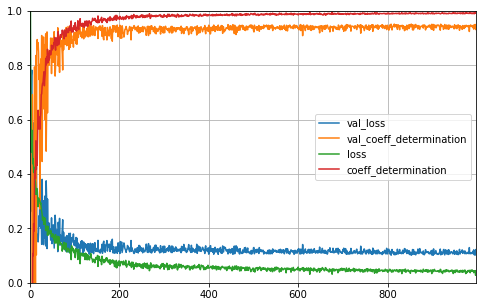

In [22]:
nn_model = create_keras_model(optimizer='Adadelta', neuron=30, init='lecun_uniform', act_alpha=0.05)
print("Keras model constructed")
early_stopping_cb = EarlyStopping(patience=20)
history = nn_model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=1000, callbacks=[], verbose=1)
pd.DataFrame(history.history).plot(figsize=(8, 5), ylim=(0, 1))
plt.grid(True)
plt.show()

#save_keras_model(nn_model, history)